In [1]:
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import datetime

import torch
import torch.optim as optim
import torch.nn as nn

import torchvision.models as models

from csfnst.utils import load_image, plot_image_tensor, save_image_tensor
from csfnst.utils import rename_network_layers, replace_network_layers, get_criterion
from csfnst.losses import PerceptualLoss

/home/s0555912/venv/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
output_image_file = '../images/output/htw-test.jpg'
style_image_file = 'license-checked/the_scream.jpg'
content_image_file = '../images/content/htw-768x768.jpg'

use_lbfgs = True
force_cpu = True
use_random_noise = False
content_image_size = 128
style_image_size = 768
epochs = 10

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() and not force_cpu else 'cpu')
content_image = load_image(content_image_file, size=content_image_size, normalize=False).to(device)
style_image = load_image(f'../images/style/{style_image_file}', size=style_image_size, normalize=False).to(device)

if use_random_noise:
    output_image = torch.rand(content_image.shape[0], content_image.shape[1], content_image.shape[2]).to(device)
else:
    output_image = content_image.clone().to(device)

In [4]:
config = {
    'loss_network': 'vgg16',
    'content_weight': 1,
    'style_weight': 1e8,
    'total_variation_weight': 1e-5,
    'style_image': style_image_file,
    'style_image_size': style_image_size,
    'content_layers': ['relu3_3'],
    'style_layers': ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3']
}

criterion = get_criterion(config, device='cpu' if force_cpu else 'cuda')
optimizer = optim.LBFGS([output_image]) if use_lbfgs else optim.Adam([output_image], lr=1e-1)

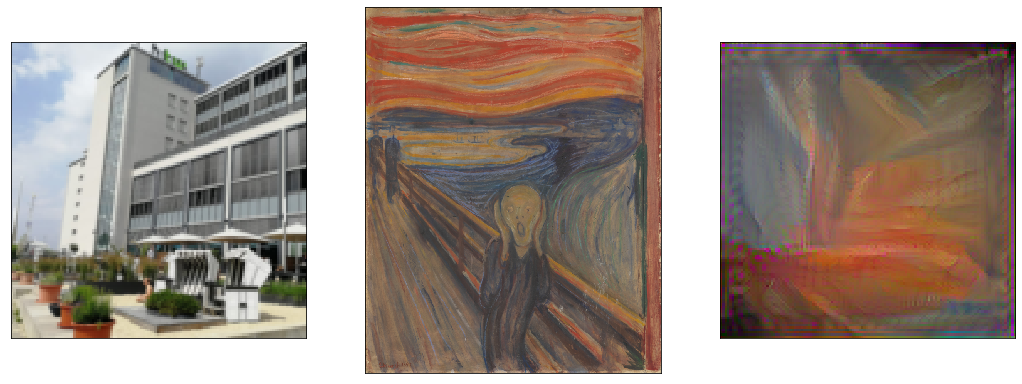

In [5]:
content_image.unsqueeze_(0)
output_image.unsqueeze_(0)
output_image.requires_grad_()

content_loss_history = []
style_loss_history = []
total_variation_loss_history = []
loss_history = []

progress_bar = tqdm_notebook(range(epochs))

if use_lbfgs:
    for epoch in progress_bar:
        def closure():
            output_image.data.clamp_(0, 1)
            optimizer.zero_grad()

            loss = criterion(output_image, content_image)
            loss.backward()
            
            content_loss_history.append(criterion.content_loss_val)
            style_loss_history.append(criterion.style_loss_val)
            total_variation_loss_history.append(criterion.total_variation_loss_val)
            loss_history.append(criterion.loss_val)

            progress_bar.set_description(f'Loss: {loss.item():,.2f}')

            return loss

        optimizer.step(closure)
else:
    for epoch in progress_bar:
        output_image.data.clamp_(0, 1)
        optimizer.zero_grad()

        loss = criterion(output_image, content_image)
        loss.backward()
        
        content_loss_history.append(criterion.content_loss_val)
        style_loss_history.append(criterion.style_loss_val)
        total_variation_loss_history.append(criterion.total_variation_loss_val)
        loss_history.append(criterion.loss_val)

        progress_bar.set_description(f'Loss: {loss.item():,.2f}')

        optimizer.step()


content_image.squeeze_()

output_image.detach_()
output_image.squeeze_()
output_image.data.clamp_(0, 1)

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18, 20)

plot_image_tensor(content_image, ax=axes[0])
plot_image_tensor(style_image, ax=axes[1])
plot_image_tensor(output_image, ax=axes[2])

save_image_tensor(output_image, output_image_file)

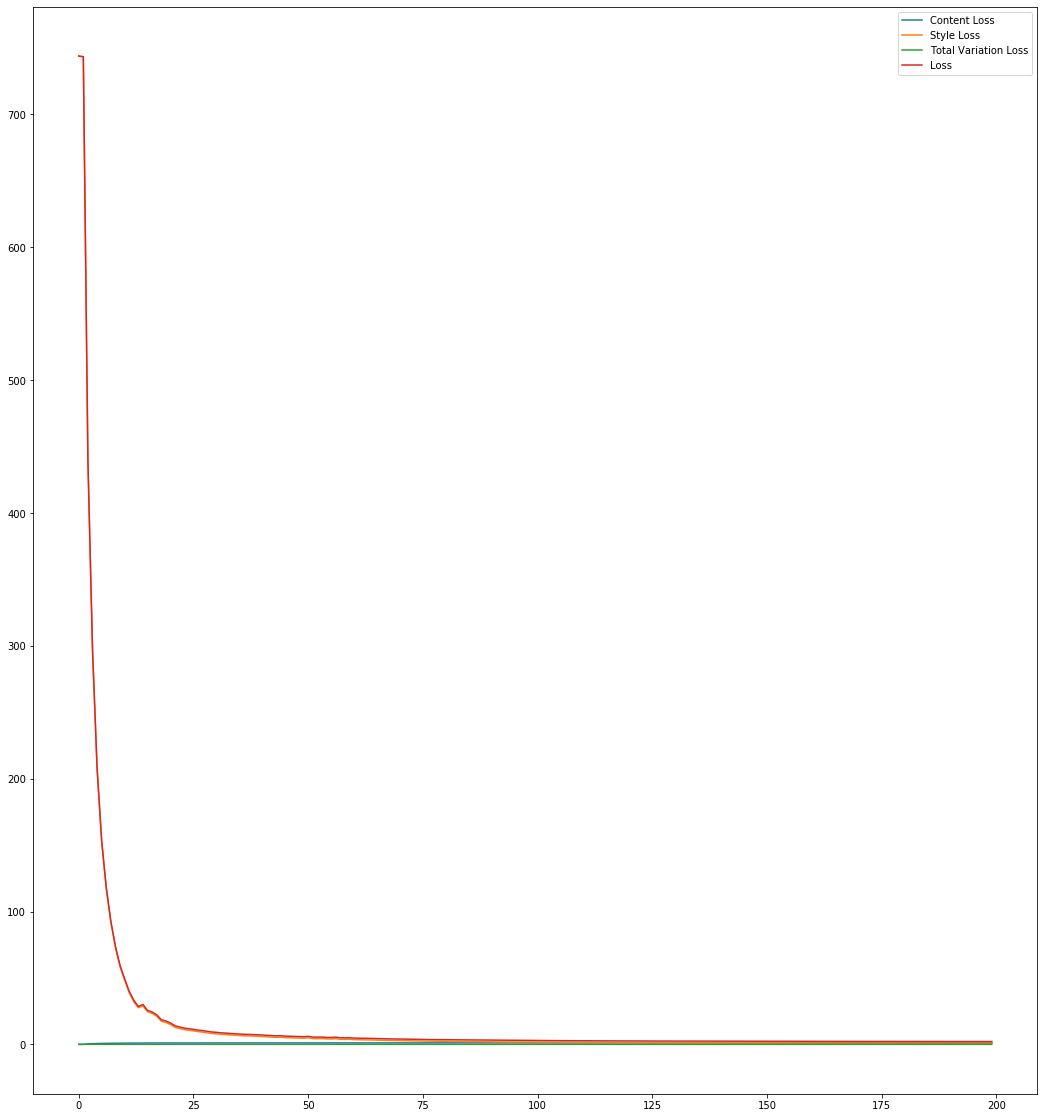

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(18, 20))  
axes.plot(content_loss_history, label='Content Loss')
axes.plot(style_loss_history, label='Style Loss')
axes.plot(total_variation_loss_history, label='Total Variation Loss')
axes.plot(loss_history, label='Loss')
plt.legend()
plt.show()

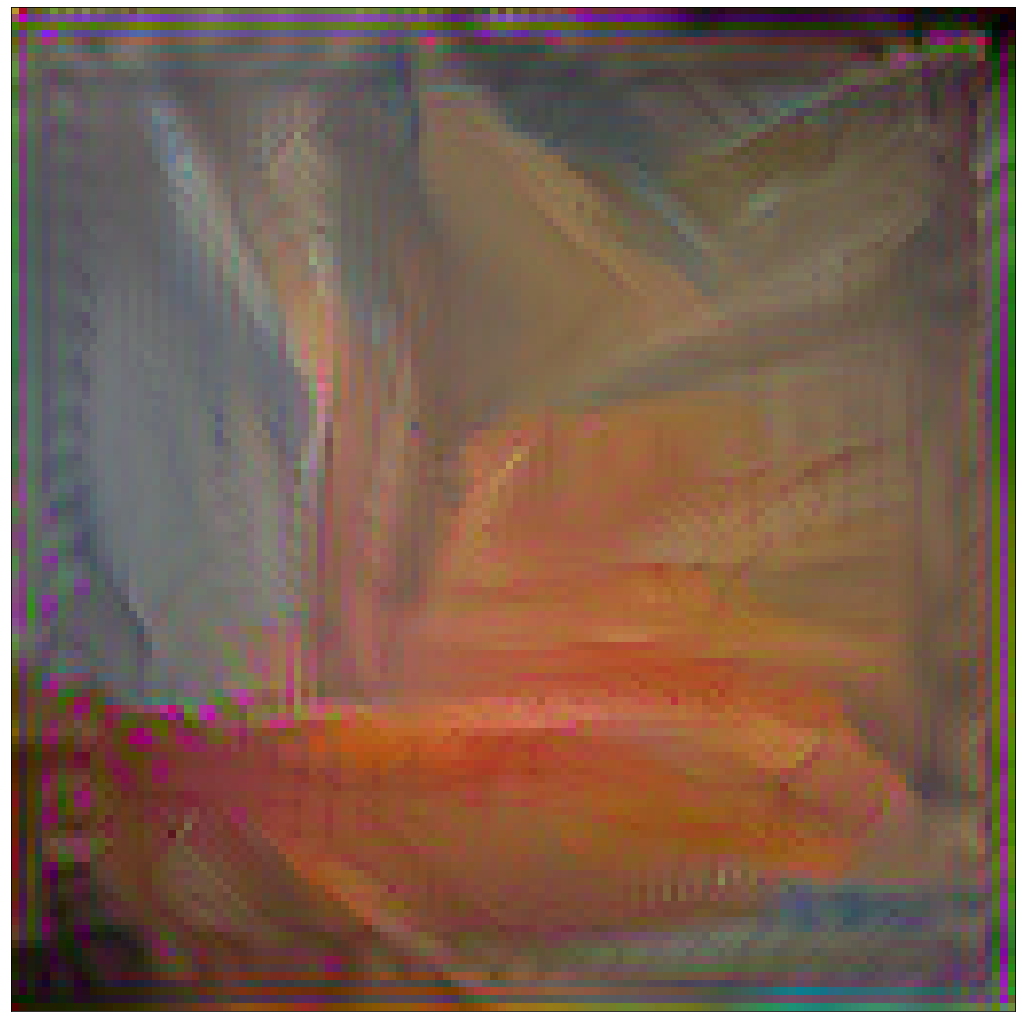

In [7]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18, 20)
plot_image_tensor(output_image, ax=ax, show=True)